# Naive Classifier for category recognition

## Packages

In [1]:
library(tidyverse)
library(ggplot2)
library(stopwords)
library(tidytext)
library(stringr)
library(purrr)
library(magrittr)
library(parallel)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.2.0     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0

── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract




In [2]:
numCores <- detectCores()

# Reading the data

### Kaggle dataset

In [3]:
train.filename <- 'dataset/archive/train.csv'
test.filename <- 'dataset/archive/test.csv'

In [4]:
train.df <- read.delim(train.filename, sep = ',')
test.df <- read.delim(test.filename, sep = ',')

In [5]:
train.df %>%
    filter(grepl("economy", Text_Tag))%>%
    filter(!grepl("health-care", Text_Tag)) %>%
    filter(!grepl("taxes", Text_Tag))%>% mutate(Labels=0) -> economy

train.df %>%
    filter(!grepl("economy", Text_Tag))%>%
    filter(grepl("health-care", Text_Tag)) %>%
    filter(!grepl("taxes", Text_Tag))%>% mutate(Labels=1) -> health_care

train.df %>%
    filter(!grepl("economy", Text_Tag))%>%
    filter(!grepl("health-care", Text_Tag)) %>%
    filter(grepl("taxes", Text_Tag)) %>% mutate(Labels=2) -> taxes

train.df<- rbind(economy, health_care, taxes)

### Second dataset

# Display the train and test datasets

In [6]:
head(train.df)

,Labels,Text,Text_Tag
,<dbl>,<chr>,<chr>
1,0,The economic turnaround started at the end of my term.,"economy,jobs"
2,0,"Since 2000, nearly 12 million Americans have slipped out of the middle class and into poverty.","economy,jobs,new-hampshire-2012,poverty"
3,0,"Almost 100,000 people left Puerto Rico last year.","bankruptcy,economy,population"
4,0,Women and men both are making less when you adjust for inflation than when John Kitzhaber was first elected governor.,"economy,income"
5,0,We just had the best year for the auto industry in America in history.,economy
6,0,Youth unemployment in minority communities is about 40 to 45 percent.,"diversity,economy,jobs"


In [ ]:
head(test.df)

# Splitting the datasets

In [7]:
# shuffle
set.seed(29062023)
train.df=train.df[sample(1:nrow(train.df), replace = F),] # shuffle the dataset

In [8]:
# set splitting percentages
perc_split <- 0.8  # set splitting percentages
n_rows <- nrow(train.df)
n_rows_train <- floor(n_rows * perc_split)

In [9]:
# splitting
train.df.train <- train.df[1:n_rows_train, ]
train.df.validation <- train.df[-c(1:n_rows_train), ]

In [10]:
cat('Total rows:',nrow(train.df),
    '\nTrain rows:',nrow(train.df.train),
    '\nValidation rows',nrow(train.df.validation))

Total rows: 2803 
Train rows: 2242 
Validation rows 561

## Histogram of labels

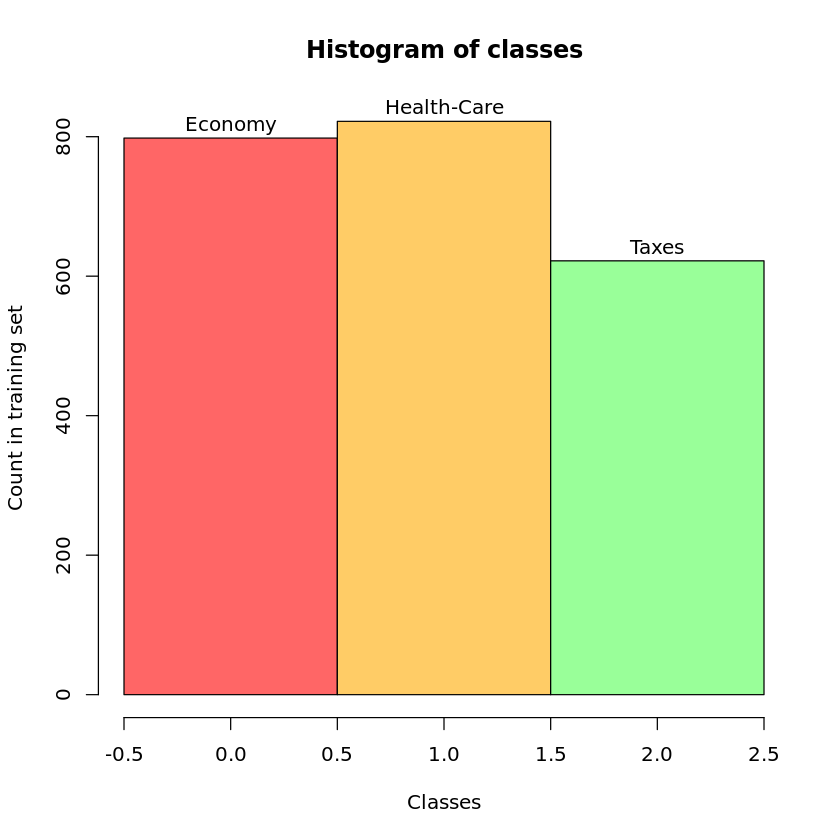

In [12]:
breaks <- seq(from=-0.5, to=2.5, by=1)
labels <- c('Economy', 'Health-Care', 'Taxes')
colors <- c('#FF6666', '#FFCC66', '#99FF99' ,'#00FF99')

classes<-hist(x = train.df.train$Labels, 
     breaks = breaks, 
     labels = labels,
     main = 'Histogram of classes',
     xlab = 'Classes',
     ylab = 'Count in training set',
     col = colors
    )

In [13]:
n_classes <- length(labels)

## Defining the prior of each classes

In [14]:
prior.classes<-classes$density

## Stop words

In [15]:
as.list(get_stopwords())$word

[1] "i"          "me"         "my"         "myself"     "we"        
  [6] "our"        "ours"       "ourselves"  "you"        "your"      
 [11] "yours"      "yourself"   "yourselves" "he"         "him"       
 [16] "his"        "himself"    "she"        "her"        "hers"      
 [21] "herself"    "it"         "its"        "itself"     "they"      
 [26] "them"       "their"      "theirs"     "themselves" "what"      
 [31] "which"      "who"        "whom"       "this"       "that"      
 [36] "these"      "those"      "am"         "is"         "are"       
 [41] "was"        "were"       "be"         "been"       "being"     
 [46] "have"       "has"        "had"        "having"     "do"        
 [51] "does"       "did"        "doing"      "would"      "should"    
 [56] "could"      "ought"      "i'm"        "you're"     "he's"      
 [61] "she's"      "it's"       "we're"      "they're"    "i've"      
 [66] "you've"     "we've"      "they've"    "i'd"        "you'd"     
 [71] "he'd"       "she'd"      "we'd"       "they'd"     "i'll"      
 [76] "you'll"     "he'll"      "she'll"     "we'll"      "they'll"   
 [81] "isn't"      "aren't"     "wasn't"     "weren't"    "hasn't"    
 [86] "haven't"    "hadn't"     "doesn't"    "don't"      "didn't"    
 [91] "won't"      "wouldn't"   "shan't"     "shouldn't"  "can't"     
 [96] "cannot"     "couldn't"   "mustn't"    "let's"      "that's"    
[101] "who's"      "what's"     "here's"     "there's"    "when's"    
[106] "where's"    "why's"      "how's"      "a"          "an"        
[111] "the"        "and"        "but"        "if"         "or"        
[116] "because"    "as"         "until"      "while"      "of"        
[121] "at"         "by"         "for"        "with"       "about"     
[126] "against"    "between"    "into"       "through"    "during"    
[131] "before"     "after"      "above"      "below"      "to"        
[136] "from"       "up"         "down"       "in"         "out"       
[141] "on"         "off"        "over"       "under"      "again"     
[146] "further"    "then"       "once"       "here"       "there"     
[151] "when"       "where"      "why"        "how"        "all"       
[156] "any"        "both"       "each"       "few"        "more"      
[161] "most"       "other"      "some"       "such"       "no"        
[166] "nor"        "not"        "only"       "own"        "same"      
[171] "so"         "than"       "too"        "very"       "will"

# Cleaning function

In [16]:
cleaning_tokens <- function(token.df){
    word <- ifelse(endsWith(token.df[,1], "s"), substr(token.df[,1], 1, nchar(token.df[,1]) - 1), token.df[,1])
    word <- ifelse(endsWith(word, "'"), substr(word, 1, nchar(word) - 1), word)
    word <- ifelse(str_detect(word, "[0-9]+"), '--number--', word)
    return(as.data.frame(word))
}

# Vocabulary

In [18]:
tags_numbers <- list(tags = labels,
                     numbers = c(0:2))

### Vocabulary before feature selection

In [19]:
vocabulary <- function(train.df.train, tags_numbers){
    #take in input a df with 'Text' column containing the messages and 'tag_numbers' the names of the labels
    
    myframes <- list()

    for (i in 1:length(tags_numbers$tags)) {
        tag <- tags_numbers$tags[i]

        train.df.train %>%
        filter(Labels == tags_numbers$numbers[i]) %>%
        select(Text) %>%
        unnest_tokens(word, Text) %>%
        anti_join(get_stopwords(), by = join_by(word)) %>%
        cleaning_tokens %>%
        arrange(word) %>%
        group_by(word) %>%
        reframe(counts = n()) %>%
        arrange(desc(counts)) %>%
        setNames(c("word", tag)) -> myframes[[i]]
    } 
    counts<-purrr::reduce(myframes, dplyr::full_join, by = 'word')
    counts %<>% replace(is.na(.),0)
    return(counts)
}

# Feature Selection 

## Rankings

### Ranking per class
Ranks by a certain metric (df_rank) per class

In [20]:
ranking_per_class <- function(df_rank, counts, n_classes, frac = 0.5) {
    mywords <- list()
    for (i in 2:(n_classes + 1)) {
        df_rank[, c(1, i)] %>%
            arrange(desc(.[[2]])) %>%
            top_frac(frac, .[[2]]) %>%
            select(word) -> mywords[[i]]
    }
    words <- purrr::reduce(mywords, rbind)
    words %<>%
        unique

    counts %>%
        right_join(words["word"], by = join_by(word)) -> naive.bayes.vocabulary

    return(naive.bayes.vocabulary)
}

### Ranking by mean of classes
Ranks by a certain metric (df_rank) by mean

In [21]:
ranking_per_mean <- function(df_rank, counts, n_classes, frac = 0.5) {
    df_rank["mean"] <- rowMeans(df_rank[2:(n_classes + 1)])

    df_rank %>%
        arrange(desc(mean)) %>%
        top_frac(frac, mean) %>%
        select(word) -> vocabulary.train.features

    counts %>%
        right_join(vocabulary.train.features["word"], by = join_by(word)) -> naive.bayes.vocabulary

    return(naive.bayes.vocabulary)
}

# Frequency

## Frequency by mean 

In [22]:
feature_selection.frequency_mean <- function(counts, n_classes, frac = 0.5) {
    counts %>%
        select(-word) %>%
        colSums() -> tot_counts_per_class

    counts_prob <- cbind(counts["word"], counts[2:(n_classes + 1)]/tot_counts_per_class)
    
    return(ranking_per_mean(counts_prob, counts, n_classes, frac))
}

## Frequency per class

In [23]:
feature_selection.frequency_per_class <- function(counts, n_classes, frac = 0.5) {
    return(ranking_per_class(counts, counts, n_classes, frac))
}

# Chi squared

In [24]:
word_chi_squared <- function(word, train.df.train, n_classes) {
    if (word != "--number--") {
        train.df.train %>%
            group_by(Labels, .drop = FALSE) %>%
            filter(grepl(word, Text, ignore.case = TRUE)) %>%
            summarise(c = n()) -> yw_c

        train.df.train %>%
            group_by(Labels, .drop = FALSE) %>%
            filter(!grepl(word, Text, ignore.case = TRUE)) %>%
            summarise(c = n()) -> nw_c
    } else {
        train.df.train %>%
            group_by(Labels, .drop = FALSE) %>%
            filter(grepl("[0-9]+", Text, ignore.case = TRUE)) %>%
            summarise(c = n()) -> yw_c

        train.df.train %>%
            group_by(Labels, .drop = FALSE) %>%
            filter(!grepl("[0-9]+", Text, ignore.case = TRUE)) %>%
            summarise(c = n()) -> nw_c
    }

    chi <- vector(length = n_classes)
    for (i in 1:n_classes) {
        n11 <- yw_c[yw_c$Labels == (i - 1), ]$c
        n10 <- sum(yw_c[yw_c$Labels != (i - 1), ]$c)
        n01 <- nw_c[yw_c$Labels == (i - 1), ]$c
        n00 <- sum(nw_c[nw_c$Labels != (i - 1), ]$c)

        chi[i] <- ((n11 + n10 + n01 + n00) * (n11 * n00 - n10 * n01)^2)/((n11 + n01) *
            (n11 + n10) * (n10 + n00) * (n01 + n00))
    }
    chi[is.na(chi)] = 0

    return(chi)

}

In [25]:
vocabulary_chi_squared <- function(counts,  train.df.train, n_classes, numCores=numCores) {
    
    df <- mclapply(X = counts$word, FUN = word_chi_squared, train.df.train = train.df.train,
        n_classes = n_classes, mc.cores = numCores)

    chi <- cbind(counts[, 1], as.data.frame(do.call(rbind, df)))
    
    return(chi)
}

## Chi by mean

In [26]:
feature_selection.chi_squared_per_mean <- function(counts, train.df.train, n_classes,
    frac = 0.5) {

    chi<- vocabulary_chi_squared(counts, train.df.train, n_classes, numCores)

    return(ranking_per_mean(chi, counts, n_classes, frac))
}

## Chi by class

In [27]:
feature_selection.chi_squared_per_class <- function(counts, train.df.train, n_classes,
    frac = 0.5) {

    chi <- vocabulary_chi_squared(counts, train.df.train, n_classes, numCores)

    return(ranking_per_class(chi, counts, n_classes, frac))
}

# Mutual information

## Mutual information per class

In [28]:
word_mutual_info <- function(word, train.df.train, n_classes) {
    if (word != "--number--") {
        train.df.train %>%
            group_by(Labels, .drop = FALSE) %>%
            filter(grepl(word, Text, ignore.case = TRUE)) %>%
            summarise(c = n()) -> yw_c

        train.df.train %>%
            group_by(Labels, .drop = FALSE) %>%
            filter(!grepl(word, Text, ignore.case = TRUE)) %>%
            summarise(c = n()) -> nw_c
    } else {
        train.df.train %>%
            group_by(Labels, .drop = FALSE) %>%
            filter(grepl("[0-9]+", Text, ignore.case = TRUE)) %>%
            summarise(c = n()) -> yw_c

        train.df.train %>%
            group_by(Labels, .drop = FALSE) %>%
            filter(!grepl("[0-9]+", Text, ignore.case = TRUE)) %>%
            summarise(c = n()) -> nw_c
    }

    MI <- vector(length = n_classes)
    for (i in 1:n_classes) {
        n11 <- yw_c[yw_c$Labels == (i - 1), ]$c
        n10 <- sum(yw_c[yw_c$Labels != (i - 1), ]$c)
        n01 <- nw_c[yw_c$Labels == (i - 1), ]$c
        n00 <- sum(nw_c[nw_c$Labels != (i - 1), ]$c)
        n1_ <- n11 + n10
        n0_ <- n01 + n00
        n_1 <- n01 + n11
        n_0 <- n10 + n00
        n <- n11 + n01 + n10 + n00
        MI[i] <- n11/n * log2(n * n11/(n1_ * n_1)) + n01/n * log2(n * n01/(n0_ *
            n_1)) + n10/n * log2(n * n10/(n1_ * n_0)) + n00/n * log2(n * n00/(n0_ *
            n_0))
    }
    MI[is.na(MI)] = 0

    return(MI)

}

In [29]:
vocabulary_mutual_info <- function(counts,  train.df.train, n_classes, numCores=numCores) {
    
    df <- mclapply(X = counts$word, FUN = word_mutual_info, train.df.train = train.df.train,
        n_classes = n_classes, mc.cores = numCores)

    mutual_info <- cbind(counts[, 1], as.data.frame(do.call(rbind, df)))
    
    return(mutual_info)
}

## Mutual by class

In [30]:
feature_selection.mutual_info_per_class <- function(counts, train.df.train, n_classes,
    frac = 0.5) {

    mutual_info <- vocabulary_mutual_info(counts, train.df.train, n_classes, numCores)

    return(ranking_per_class(mutual_info, counts, n_classes, frac))
}

## Mutual by mean

In [31]:
feature_selection.mutual_info_per_mean <- function(counts, train.df.train, n_classes,
    frac = 0.5) {

    mutual_info <- vocabulary_mutual_info(counts, train.df.train, n_classes, numCores)

    return(ranking_per_mean(mutual_info, counts, n_classes, frac))
}

# Likelihood computation

In [32]:
likelihood.denominator <- function(naive.bayes.vocabulary) {
    naive.bayes.vocabulary %>%
        select(-word) %>%
        colSums() -> tot_counts_per_class

    den <- tot_counts_per_class + length(naive.bayes.vocabulary[[1]])
    return(den)
}

In [33]:
likelihood <- function(naive.bayes.vocabulary, den) {
    likelihood.token <- cbind(naive.bayes.vocabulary["word"], (naive.bayes.vocabulary[2:(n_classes +
        1)] + 1)/den)
    return(likelihood.token)
}

## Nayve Bayes

In [34]:
tweet_tokenize <- function(msg) {
    tib <- data.frame(msg)
    colnames(tib) <- "tweet"
    tib %>%
        unnest_tokens(word, tweet) %>%
        anti_join(get_stopwords(), by = join_by(word)) %>%
        cleaning_tokens -> token.list
    return(token.list)
}

In [35]:
bayes.probability <- function(token.list, likelihood.token, prior.classes, den, n_classes) {

    query_out <- log(as.numeric(prior.classes))
    for (i in 1:length(token.list)) {
        query <- log(as.numeric(likelihood.token[likelihood.token["word"] == token.list$word[i]][2:(n_classes +
            1)]))
        if (is.na(query[1])) {
            # because if the word is not found, all NA are returned. if the
            # word is in the vocabulary the proper likelihood is returned
            query <- as.numeric(log(1/den))
        }
        query_out <- query_out + query
    }
    query_out <- exp(query_out)
    query_out <- query_out/sum(query_out)
    return(query_out)
}

In [36]:
naive.bayes <- function(msg, likelihood.token, prior.classes, den, n_classes) {
    token.list <- as.vector(tweet_tokenize(msg))
    probability <- bayes.probability(token.list, likelihood.token, prior.classes,
        den, n_classes)
    predicted_class <- which.max(probability) - 1
    return(predicted_class)
}

# Training: creating and saving the dfs with words and countings according to feature selection method

In [45]:
fraction<-seq(from =0.1, to =1, by=0.2)

In [42]:
# Return data.frame with only counted and tokenized words
counts <- vocabulary(train.df.train, tags_numbers)

In [ ]:
for (i in seq_along(fraction)) {
    write.csv(feature_selection.frequency_per_class(counts, n_classes, frac = fraction[i]),
        file = paste("models/frequency_per_class", fraction[i], ".csv", sep = ""))
    write.csv(feature_selection.frequency_mean(counts, n_classes, frac = fraction[i]),
        file = paste("models/frequency_per_mean", fraction[i], ".csv", sep = ""))
    write.csv(feature_selection.chi_squared_per_class(counts, n_classes, frac = fraction[i]),
        file = paste("models/chi_per_class", fraction[i], ".csv", sep = ""))
    write.csv(feature_selection.chi_squared_per_mean(counts, n_classes, frac = fraction[i]),
        file = paste("models/chi_per_mean", fraction[i], ".csv", sep = ""))
    write.csv(feature_selection.mutual_info_per_class(counts, n_classes, frac = fraction[i]),
        file = paste("models/mutual_per_class", fraction[i], ".csv", sep = ""))
    write.csv(feature_selection.mutual_info_per_mean(counts, n_classes, frac = fraction[i]),
        file = paste("models/mutual_per_mean", fraction[i], ".csv", sep = ""))
}

# Run all the functions

In [47]:
acc_freq_mean <- vector()
for (i in seq_along(fraction)) {
    # Vocabulary optimized with feature selection
    naive.bayes.vocabulary <- feature_selection.mutual_info_per_class(counts,train.df.train , n_classes,
        frac = fraction[i])

    # Compute denominator of likelihood
    denominator <- likelihood.denominator(naive.bayes.vocabulary)

    # Compute the likelihood for each tokinez and unique word
    likelihood.token <- likelihood(naive.bayes.vocabulary, denominator)

    # Run the prediction
    predicted_classes <- mclapply(X = train.df.validation$Text, FUN = naive.bayes,
        likelihood.token = likelihood.token, prior.classes = prior.classes, den = denominator,
        n_classes = n_classes, mc.cores=numCores)

    # Check % of right predictions
    acc_freq_mean[i] <- sum(predicted_classes == train.df.validation$Labels)/length(train.df.validation$Labels)
}

In [48]:
acc_freq_mean

[1] 0.4509804 0.4509804 0.4705882 0.4705882 0.4705882

In [ ]:
# plot(fraction, acc_per_class, type='l', ylim = c(0,1))
# lines(fraction, acc_freq_mean, col='red')
# legend(0, 1, legend = c("freq mean", "top per class"), col = c("red", "black"), lty = 1)

# Apply to the validation set and plot accuarcies for different methods

In [39]:
file_list <- c(list.files(path = "models", pattern = "frequency_per_mean*"),
               list.files(path = "models", pattern = "frequency_per_class*"),
               list.files(path = "models", pattern = "chi_per_mean*"),
               list.files(path = "models", pattern = "chi_per_class*"),
               list.files(path = "models", pattern = "mutual_per_class*"),
               list.files(path = "models", pattern = "mutual_per_mean*"))

In [41]:
acc<-vector()
for (i in seq_along(file_list)) {

    naive.bayes.vocabulary <- read.csv(paste("./models", file_list[i], sep = "/")) %>%
        select(-X)
    # Compute denominator of likelihood
    denominator <- likelihood.denominator(naive.bayes.vocabulary)

    # Compute the likelihood for each tokinez and unique word
    likelihood.token <- likelihood(naive.bayes.vocabulary, denominator)

    # Run the prediction
    predicted_classes <- mclapply(X = train.df.validation$Text, FUN = naive.bayes,
        likelihood.token = likelihood.token, prior.classes = prior.classes, den = denominator,
        n_classes = n_classes, mc.cores = numCores)

    # Check % of right predictions
    acc[i] <- sum(predicted_classes == train.df.validation$Labels)/length(train.df.validation$Labels)
}

In [42]:
acc

[1] 0.2153320 0.2192383 0.2031250 0.2031250 0.2031250 0.2031250 0.2031250
 [8] 0.1997070 0.2143555 0.2084961

In [50]:
source('test.R')

In [51]:
t_func(22)

[1] 64